In [1]:
# # For lgpu2
# # The default HOME do not have enough space.
# import os
# print(os.path.expanduser("~"))
# os.environ["HOME"] = "/csproject/kdd/cyuab2"
# print(os.path.expanduser("~"))

In [2]:
# Clears all user-defined variables, functions, and imports without asking for confirmation.
%reset -f

In [3]:
import numpy as np
from dtaidistance import ed as dtaidistance_ed
from dtaidistance import dtw, dtw_visualisation
import pandas as pd
import matplotlib.pyplot as plt
from tslearn import metrics
from scipy.signal import sawtooth
from tqdm import tqdm
import time
from tslearn.datasets import UCR_UEA_datasets
import random

/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
# Imported Python files do not automatically reload after you modify them
# M1: Automatically Reload
%load_ext autoreload
%autoreload 2
# M2: Manual Reload
# import importlib
# import ksfdtw
# importlib.reload(ksfdtw)

# https://stackoverflow.com/questions/20309456/how-do-i-call-a-function-from-another-py-file
from ksfdtw import *

Represent time series as `np array`.

In [5]:
q = np.array([1,1,1,2,2,3,3,4]) #|q|=m=8
c = np.array([1,1,1,1,2,3,3,3,4,4,5,6,7]) #|c|=n=13
# l = 2
# k ranges from m/l = 8/2 = 4 to min(lm,n) = min(2*8,13) = 13 (i.e, k = 4..13)
# L = 13

In [6]:
len(q), len(c) # lengths

(8, 13)

A prefix of $C$ with length = 10

In [7]:
c_0_10 = c[0:10] # The first entry is included, the last entry is excluded
c_0_10

array([1, 1, 1, 1, 2, 3, 3, 3, 4, 4])

In [8]:
type(c_0_10)

numpy.ndarray

Another example

In [9]:
# Data from https://jmotif.github.io/sax-vsm_site/morea/algorithm/znorm.html
q = pd.Series(np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34]))
c = pd.Series(np.array([-0.12, -0.16, -0.13,  0.28,  0.37,  0.39,  0.18,  0.09,  0.15, -0.06,  0.06, -0.07, -0.13, -0.18, -0.26]))

In [10]:
type(q)

pandas.core.series.Series

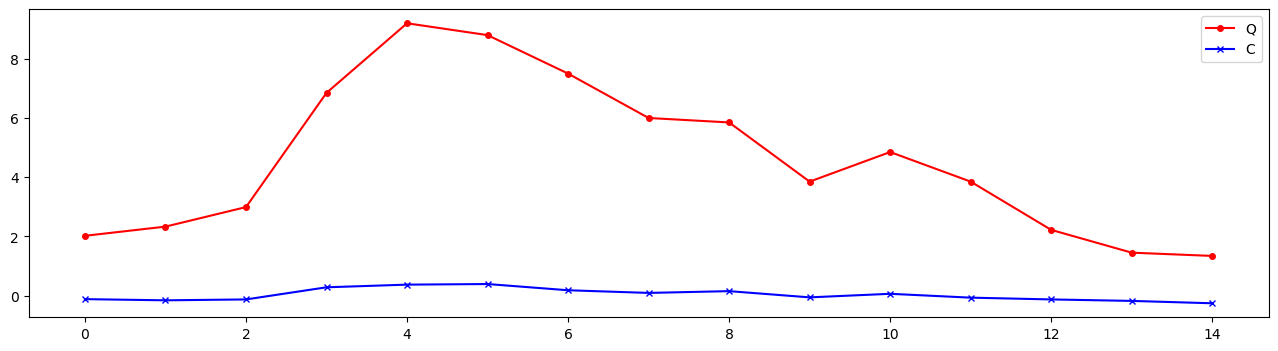

In [11]:
from sktime.utils.plotting import plot_series
fig, ax = plot_series(q, c, markers=["o", "x"], colors=["red", "blue"], labels=["Q", "C"]) 


#  Z-normalization

A simple Z-normalization function

In [12]:
def normalize(ts):
    mean = np.mean(ts)
    std = np.std(ts)
    return (ts - mean) / std

In [13]:
def normalize2(series):
    mean = series.mean()  # Calculate the mean
    std = series.std(ddof=0) # Calculate the population standard deviation instead of the default sample standard deviation
    
    # Apply z-normalization formula: (x - mean) / std
    normalized_series = (series - mean) / std
    
    return normalized_series

Standard Z-normalizer from library

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def normalize3(series):
    # Reshape the series to 2D (required by StandardScaler)
    reshaped = series.values.reshape(-1, 1)
    
    # Apply z-normalization
    scaler = StandardScaler()
    normalized = scaler.fit_transform(reshaped)
    
    # Convert back to pandas Series
    return pd.Series(normalized.flatten(), index=series.index)

z_normalize only works for `series` but not `np array`.

In [15]:
q_znorm = normalize(q)
c_znorm = normalize(c)

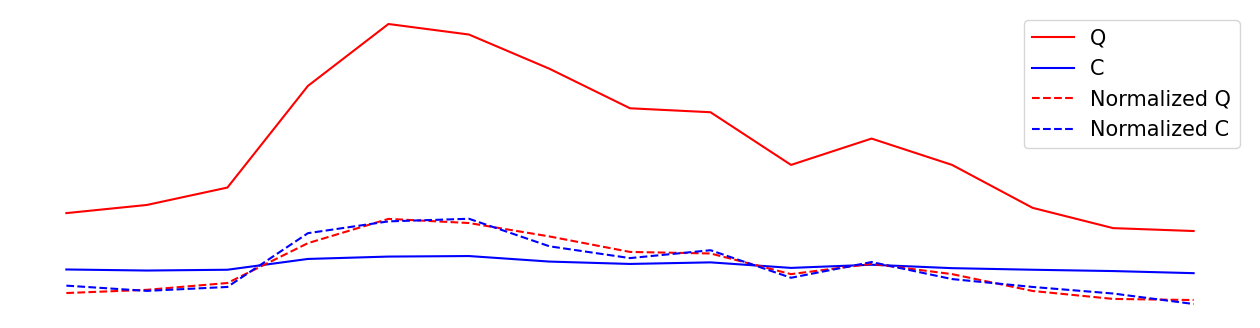

In [16]:
import matplotlib.pyplot as plt
fig, ax = plot_series(q, c, q_znorm, c_znorm, markers=[None, None, None, None], colors=["red", "blue", "red", "blue"], labels=["Q", "C", "Normalized Q", "Normalized C"]) 
# fig, ax = plot_series(q, c, q_znorm, c_znorm, markers=["o", "x", "o", "x"], colors=["red", "blue", "red", "blue"], labels=["Q", "C", "Normalized Q", "Normalized C"]) fig, ax = plot_series(q, c, q_znorm, c_znorm, colors=["red", "blue", "red", "blue"], labels=["Q", "C", "Normalized Q", "Normalized C"]) 
ax.lines[2].set_linestyle("--")  # Dashed line for the first series
ax.lines[3].set_linestyle(("--"))   # Dotted line for the second series
# https://stackoverflow.com/questions/51054529/manipulate-linestyle-in-matplotlib-legend
plt.axis('off')
ax.legend(fontsize=15)
plt.savefig("../figures/normalization.pdf", format="pdf", bbox_inches="tight")
plt.show()

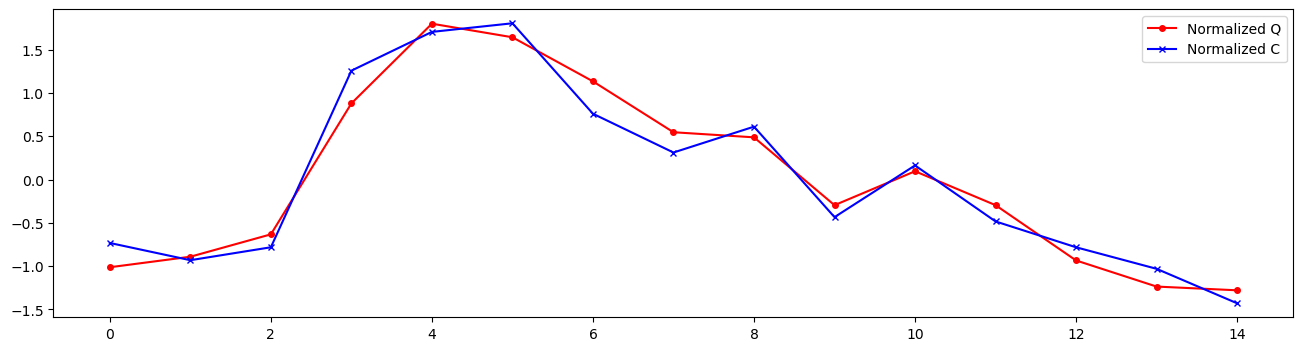

In [17]:
fig, ax = plot_series(q_znorm, c_znorm, markers=["o", "x"], colors=["red", "blue"], labels=["Normalized Q", "Normalized C"]) 
# https://stackoverflow.com/questions/51054529/manipulate-linestyle-in-matplotlib-legend
ax.legend()
plt.show()

# ED, DTW

Test ED and DTW implementations in dtaidistance

In [18]:
# Generate testing time series
np.random.seed(42)
a = np.random.random(20)
b = np.random.random(20)

In [19]:
distance = dtaidistance_ed.distance(a, b)
print(f"Distance: {distance}")

Distance: 2.3275702573015664


In [20]:
dist = 0
l = min(len(a), len(b)) # The original ed.distance can handle different lengths.
for i in range(0, l):
    dist += (a[i]-b[i])**2
print("Distance: ",np.sqrt(dist))

Distance:  2.3275702573015664


In [21]:
distance = dtw.distance(a, b)
print(f"Distance: {distance}")
distance = dtw.distance_fast(a, b)
print(f"Distance: {distance}")

Distance: 0.7494163979271871
Distance: 0.7494163979271871


In [22]:
%%time
distance = dtw.distance(a, b, window=4)
print(f"Distance: {distance}")

Distance: 0.9681751552406113
CPU times: user 276 μs, sys: 68 μs, total: 344 μs
Wall time: 286 μs


In [23]:
path = dtw.warping_path(a, b, window=4)
# path

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

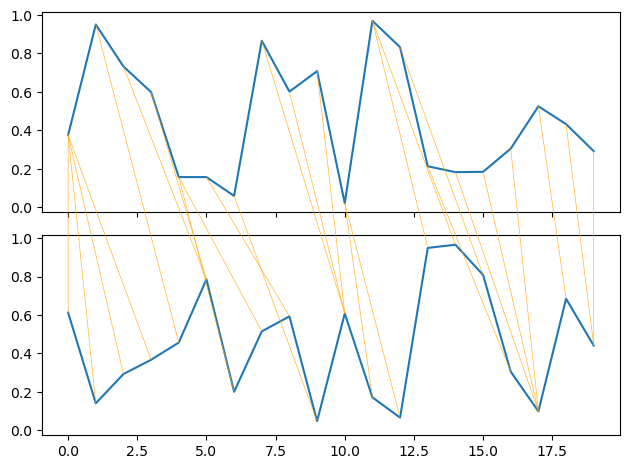

In [24]:
dtw_visualisation.plot_warping(a, b, path)

In [25]:
# Test whether the local function is ED
dist = 0
for i in range(0, len(path)):
    dist += (a[path[i][0]] - b[path[i][1]])**2
print("Distance: ",np.sqrt(dist))

Distance:  0.9681751552406113


In [26]:
# Use the self wrapped version
print(dtai_ed(a,b), dtai_dtw(a,b,_,4))

2.3275702573015664 0.9681751552406113


In [27]:
# Data from https://jmotif.github.io/sax-vsm_site/morea/algorithm/znorm.html
q = pd.Series(np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34]))
c = pd.Series(np.array([-0.12, -0.16, -0.13,  0.28,  0.37,  0.39,  0.18,  0.09,  0.15, -0.06,  0.06, -0.07, -0.13, -0.18, -0.26]))
len(q), len(c)

(15, 15)

In [28]:
dtai_ed(q, c)

19.942780648645762

# Interpolation

In [29]:
a = np.array([1,2,3,4,5,6])
nearest_neighbor_interpolation(a, 8)

array([1, 2, 2, 3, 4, 5, 5, 6])

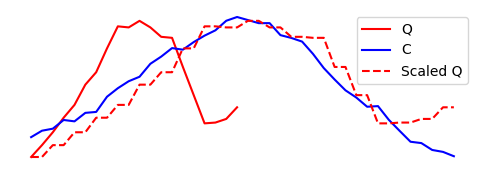

In [30]:
np.random.seed(0)
q = np.cumsum(np.random.rand(20) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 20)))
c = np.cumsum(np.random.rand(40) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 40)))
# c_x2 = np.linspace(0, 1, 10)
# c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
# c_y2 = c_y2 *5
# offset = c[-1] - c_y2[0]
# c_y2 = c_y2 + offset
# c = np.concatenate([c, c_y2])
q_scaled = nearest_neighbor_interpolation(q, len(c))

q = normalize(q)
c = normalize(c)
q_scaled = normalize(q_scaled)

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(6, 2))

ax1.plot(q, label='Q', color='red')
ax1.plot(c, label='C', color='blue')
ax1.plot(q_scaled, label='Scaled Q', linestyle='--', color='red')

# ax1.set_title('Example of US')
ax1.legend()

# https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
plt.axis('off')
# https://www.tutorialspoint.com/save-the-plots-into-a-pdf-in-matplotlib
plt.savefig("../figures/us.pdf", format="pdf", bbox_inches="tight")
plt.show()


/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


dtw_sakoechiba: 2.1256387200688422
dtw_itakura: 2.3393233353190075


/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


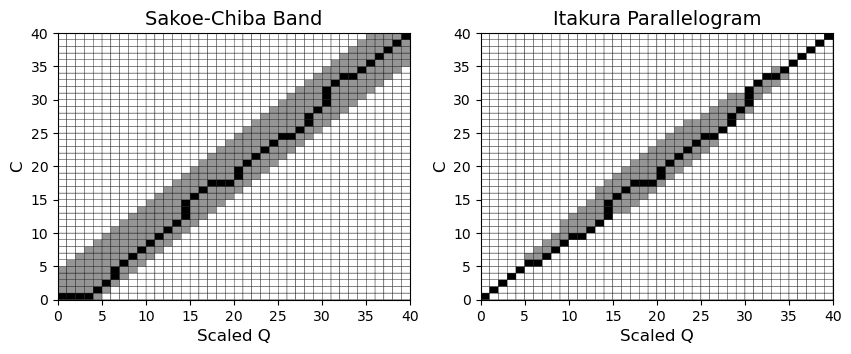

In [31]:
x = q_scaled[:50]
y = c[:50]
# x = np.array([1, 2, 3, 4])
# y = np.array([5, 6, 6, 7, 8, 8, 8])

# https://pyts.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html
# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

import numpy as np
import matplotlib.pyplot as plt
from pyts.datasets import load_gunpoint
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)

# Parameters
# X, _, _, _ = load_gunpoint(return_X_y=True)
# x, y = X[0], X[1]
# To compare time series of different lengths, we remove some observations
# mask = np.ones(x.size)
# mask[::5] = 0
# y = y[mask.astype(bool)]
n_timestamps_1, n_timestamps_2 = x.size, y.size

plt.figure(figsize=(10, 8))
timestamps_1 = np.arange(n_timestamps_1 + 1)
timestamps_2 = np.arange(n_timestamps_2 + 1)

# Dynamic Time Warping: sakoechiba
# window_size = 0.1
window_size = 0.1

dtw_sakoechiba, path_sakoechiba = dtw(
    x, y, dist='square', method='sakoechiba',
    options={'window_size': window_size}, return_path=True
)
band = sakoe_chiba_band(n_timestamps_1, n_timestamps_2,
                        window_size=window_size)
matrix_sakoechiba = np.zeros((n_timestamps_1, n_timestamps_2))
for i in range(n_timestamps_1):
    matrix_sakoechiba[i, np.arange(*band[:, i])] = 0.5
matrix_sakoechiba[tuple(path_sakoechiba)] = 1.

plt.subplot(2, 2, 1)
plt.pcolor(timestamps_1, timestamps_2, matrix_sakoechiba.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('Scaled Q', fontsize=12)
plt.ylabel('C', fontsize=12)
plt.title('Sakoe-Chiba Band', fontsize=14)
print("dtw_sakoechiba:", dtw_sakoechiba)

# Dynamic Time Warping: itakura
slope = 1.2
dtw_itakura, path_itakura = dtw(
    x, y, dist='square', method='itakura',
    options={'max_slope': slope}, return_path=True
)
parallelogram = itakura_parallelogram(n_timestamps_1, n_timestamps_2,
                                      max_slope=slope)
matrix_itakura = np.zeros((n_timestamps_1, n_timestamps_2))
for i in range(n_timestamps_1):
    matrix_itakura[i, np.arange(*parallelogram[:, i])] = 0.5
matrix_itakura[tuple(path_itakura)] = 1.
plt.subplot(2, 2, 2)
plt.pcolor(timestamps_1, timestamps_2, matrix_itakura.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('Scaled Q', fontsize=12)
plt.ylabel('C', fontsize=12)
plt.title("Itakura Parallelogram",
          fontsize=14)
print("dtw_itakura:", dtw_itakura)

# plt.suptitle("Dynamic Time Warping", y=0.995, fontsize=17)
plt.subplots_adjust(top=0.91, hspace=0.4)
# plt.grid(False)
plt.savefig("../figures/dtw-matrix.pdf", format="pdf", bbox_inches="tight")
plt.show()


Another example

In [32]:
c_x1 = np.linspace(0, 4 * np.pi, 100)
c_y1 = np.sin(c_x1) * 50 + 50  # Scale to range around 0~100
c_x2 = np.linspace(0, 1, 20)
c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
c_y2 = c_y2 * 50  # Scale it similarly
offset = c_y1[-1] - c_y2[0]
c_y2 = c_y2 + offset
c = np.concatenate([c_y1, c_y2])
q_x = np.linspace(0, 4 * np.pi, 70)
q = np.sin(q_x) * 50 + 50  # Scale to range around 0~100
m = len(q)
n = len(c)
print(m, n)


70 120


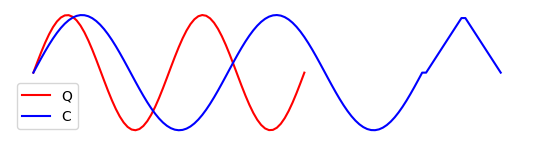

In [33]:
fig, ax1 = plt.subplots(figsize=(6, 2))
plt.plot(q, color='red', label='Q')
plt.plot(c, color='blue', label='C')
# plt.title('C vs. Q')
plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.axis('off')
plt.savefig("../figures/us-prefix.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [34]:
c_prefix = c[:100]
c_prefix_scaled = nearest_neighbor_interpolation(c_prefix, len(q))

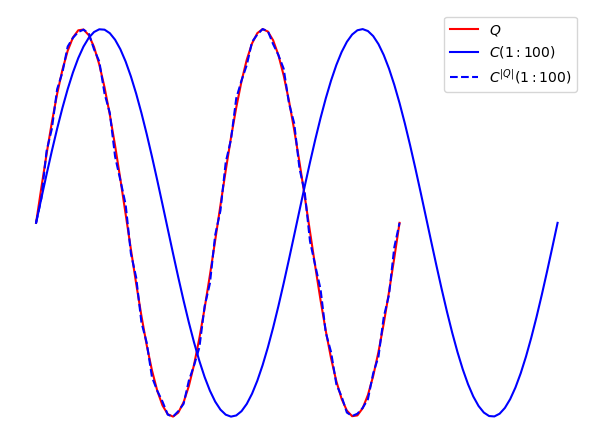

In [35]:
plt.plot(q, color='red', label='$Q$')
# plt.plot(c, color='blue', label='$C$')
plt.plot(c_prefix, color='blue', label='$C(1:100)$')
plt.plot(c_prefix_scaled, linestyle='--', color='blue', label='$C^{|Q|}(1:100)$')
# plt.title('c_prefix vs. c_prefix_interpolated')
plt.legend()
plt.tight_layout()
plt.axis('off')
plt.show()


Simply performing dtw on Q and C returns a bad result.

As shown in the above graph, Q and scaled C(1:100) have a good match.

In [36]:
dtai_ed(q, c_prefix_scaled)

10.750017785167758

Test for USDTW. It select the most similar prefix $C(0:k)$ and compare it with $Q$.

In [37]:
l = 2 # scaling_factor 
L = min(np.ceil(l * len(q)), len(c))
best_so_far, best_k = us_usdtw(q, c, l, 0.1, L, "ed")

In [38]:
best_so_far, best_k, best_k/m*100 # best_k/m*100 is the best scaling factor

(26.180324399082302, 100, 142.85714285714286)

# Lower Bounds for Distance Measures

In [39]:
# Sample sequences
np.random.seed(18)
q = np.sin(np.linspace(0, 4 * np.pi, 100))
c = q + np.random.normal(0, 0.4, size=100)

In [40]:
def lb_shen_argmin_q_of_cj(q, c, l=1, r=0.1):
    if isinstance(r, float):
        # print("r is a float.")
        minlen = min(len(a), len(b))
        r = int(minlen * r)
    elif isinstance(r, int):
        # Do something when r is an int
        # print("r is an integer.")
        # window=r
        pass
    else:
        raise ValueError("r must be either an integer or a float.")
    m = len(q)
    n = len(c)
    dist = lambda a, b: (a - b)**2

    window_contrib = []
    dist_total = 0
    # window_contrib.append((0, 0))
    dist_total += dist(q[0], c[0]) 
    window_contrib.append(q[0]) # Window for c_o
    
    for j in range(1, min(np.ceil(l*m), n - 1)):
        start = int(max(0, np.ceil(j/l) - r))
        end = int(min(np.ceil(j*l) + r, m-1))
        # print(j, start, end)
        q_window = q[start:end+1]
        # print("q_window ", q_window)
        argmin = np.argmin([dist(c[j], q_k) for q_k in q_window]) #q_k = q_argmin
        min_dist = 0
        min_dist = dist(c[j], q_window[argmin])
        # print(min_dist)
        # min_dist = np.min([dist(c[j], q_k) for q_k in q_window])
        # window_contrib.append((j, q_window[argmin]))
        window_contrib.append(q_window[argmin])
        dist_total += min_dist
    dist_total += dist(q[-1], c[-1])
    window_contrib.append(q[-1]) 
    return np.sqrt(dist_total), window_contrib

In [41]:
c

array([ 0.03177138,  1.0026734 ,  0.19719113,  0.43586965,  0.66327587,
        0.84226451,  1.09364041,  0.93384598,  0.71517075,  0.65126941,
        1.27708532,  1.15138489,  1.22871524,  0.55618624,  0.5808997 ,
        1.48320861,  1.1287409 ,  1.04746534,  1.58256832,  0.55063935,
        0.80760589,  0.23241579, -0.12516052, -0.18849036,  0.44846386,
       -0.24522573, -0.69817427, -0.18969495, -0.0429886 ,  0.03462658,
        0.36732166, -0.26153362, -1.1234475 , -0.83903975, -0.49146779,
       -1.18526014, -0.71877451, -0.58327665, -1.6944072 , -0.92434377,
       -0.4786674 , -0.61061931, -0.69212188, -0.7407006 ,  0.18440783,
       -0.55874809, -1.07104488, -0.49913415, -0.12978819,  0.07772442,
       -0.03683643,  0.22370246,  0.2439675 ,  0.77006215,  0.09313415,
        0.61324194,  0.16931217,  0.3666184 ,  1.03043741,  0.75691819,
        1.35984172,  1.01671829,  1.21366002,  1.47641133,  0.74147088,
        0.00589544,  0.263975  ,  0.29866598,  0.52813921,  0.12

In [42]:
dist = lb_shen(q, c, l=1, r=5)
# dist = lb_kim(q, c, r=5)
# dist = lb_kim_fl(q, c, r=5)
dist

np.float64(2.2637676038911785)

In [43]:
dtai_dtw(q, c, r =5)

3.7060581448719647

Test for $LB_{Keogh}$ from `tslearn`

In [44]:
# LB_Keogh
env_low, env_up = metrics.lb_envelope(q, radius=5)
metrics.lb_keogh(ts_query=c, envelope_candidate=(env_low, env_up))


np.float64(2.240514607517655)

In [45]:
metrics.lb_keogh(ts_query=c, ts_candidate=q, radius=5)

np.float64(2.240514607517655)

$LB_{Shen}$ lower bounds DTW.

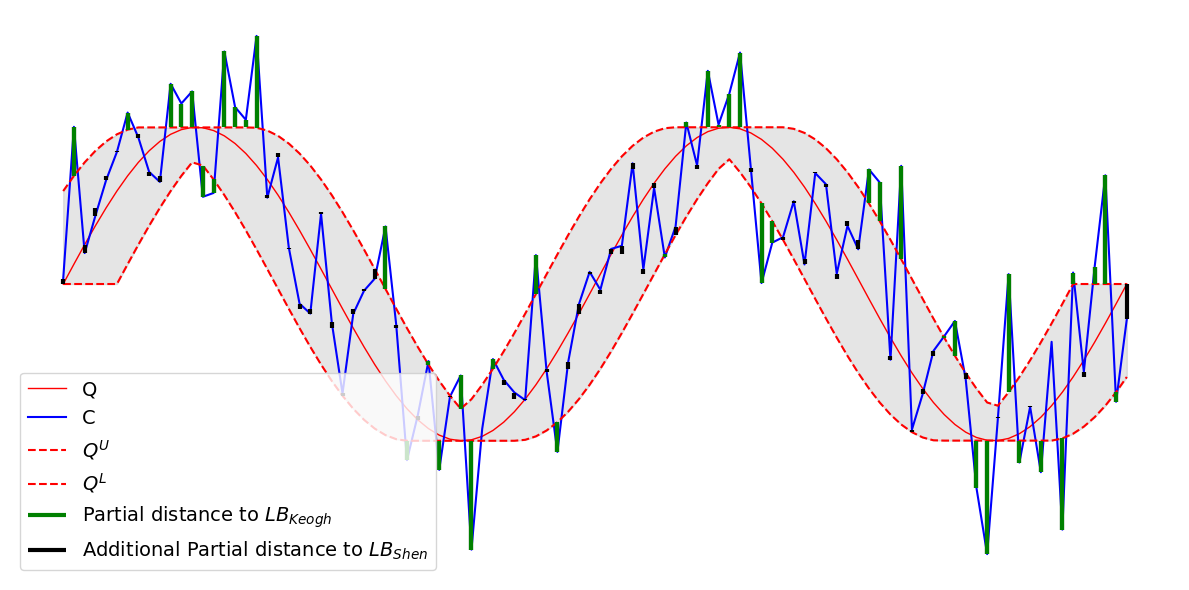

In [46]:
def plot_lb_keogh_full(q, c, radius):
    x = np.arange(len(q))
    lower, upper = lb_keogh_envelope(q, radius)
    lb = lb_keogh(q, c, radius)

    plt.figure(figsize=(12, 6))

    # Plot Q and C
    plt.plot(x, q, label='Q', color='red', linewidth=1)
    plt.plot(x, c, label='C', color='blue', linewidth=1.5)
    # Plot envelope
    plt.plot(x, upper, label='$Q^U$', linestyle='--', color='red', linewidth=1.5)
    plt.plot(x, lower, label='$Q^L$', linestyle='--', color='red', linewidth=1.5)
    plt.fill_between(x, lower, upper, color='gray', alpha=0.2)
    # Vertical bars
    # Old version
    # for i in x:
    #     if c[i] > upper[i]:
    #         plt.vlines(i, upper[i], c[i], color='black', linewidth=1.5)
    #     elif c[i] < lower[i]:
    #         plt.vlines(i, lower[i], c[i], color='black', linewidth=1.5)

#     print(len(lower))
    lb_shen_dist, first_pair_smallest_elts_last_pair = lb_shen_argmin_q_of_cj(q, c, r=5)
#     print(lb_shen_dist)
#     print(len(np.array(first_pair_smallest_elts_last_pair)))
    plt.vlines(np.arange(len(q)), c, first_pair_smallest_elts_last_pair,
           label='Additional Partial distance to $LB_{Shen}$', color='black', linewidth=3.0)
    # Elegant version
    plt.vlines(np.arange(len(q)), c, np.clip(c, lower, upper),
           label='Partial distance to $LB_{Keogh}$', color='green', linewidth=3.0)

    # plt.title(f"LB_Keogh Visualization\nLower Bound = {lb:.4f}")
    # plt.xlabel("Time Index")
    # plt.ylabel("Value")

    # Get all legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    # Swap the last two (assuming they are in the expected order)
    handles[-2], handles[-1] = handles[-1], handles[-2]
    labels[-2], labels[-1] = labels[-1], labels[-2]

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=14)
    # ax.legend(fontsize=25)
    # plt.legend(loc='upper right')
    # plt.grid(True)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("../figures/lb_keogh-lb_shen.pdf", format="pdf", bbox_inches="tight")
    plt.show()

plot_lb_keogh_full(q, c, radius=5)



Create toy example for testing the idea of PSDTW.

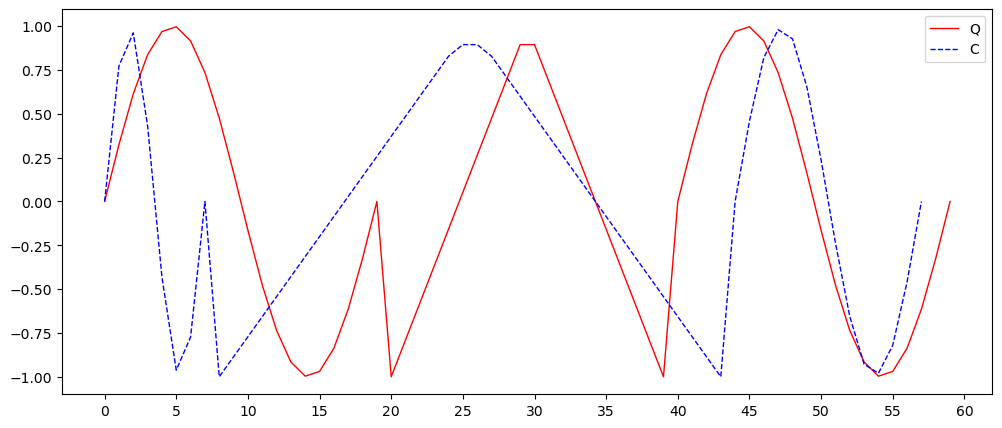

(60, 58)

In [47]:
# Step 1: Create segments
def generate_segments():
    s1 = np.sin(np.linspace(0, 2 * np.pi, 20)) #30
    # s1 = np.linspace(0, 1, 15)
    s2 = sawtooth(np.linspace(0, 2 * np.pi, 20), 0.5)  # Triangle wave (periodic) # 20
    # s2 = np.concatenate([np.ones(10), np.linspace(1, 0.5, 5)])
    s3 = np.tile([-1, 1], 20)
    tail = np.linspace(1, 0, 30)
    return s1, s2, s3, tail
    # return s1, s2, tail

# Step 3: Compose sequences
def create_series(with_tail=False):
    s1, s2, s3, tail = generate_segments()
    # s1, s2, tail = generate_segments()
    Q = np.concatenate([s1, s2, s1])
    # Q = np.concatenate([s1, s2])
    C = np.concatenate([
        linear_interpolation(s1, int(len(s1)*0.4)),
        linear_interpolation(s2, int(len(s2)*1.8)),
        linear_interpolation(s1, int(len(s1)*0.7))
    ])
    if with_tail:
        C = np.concatenate([C, tail])
    return Q, C

Q, C = create_series(False)

# Step 4: Plotting with ground truth segment boundaries
def plot_segmented_series(Q, C):
    plt.figure(figsize=(12, 5))
    plt.plot(Q, label="Q", color='red', linewidth=1)
    plt.plot(C, label="C", color='blue', linestyle='--', linewidth=1)

    # for idx in q_segments[1:-1]:  # skip 0 and end
    #     plt.axvline(idx, color='blue', linestyle='--', alpha=0.5)
    # for idx in c_segments[1:-1]:
    #     plt.axvline(idx, color='red', linestyle=':', alpha=0.5)

    # plt.title("Segmented Time Series with Expression Rate Difference + Tail")
    from matplotlib.ticker import MultipleLocator
    plt.gca().xaxis.set_major_locator(MultipleLocator(5))
    plt.legend()
    # plt.grid(True)
    # plt.xlabel("Time index")
    # plt.ylabel("Value")
    plt.show()

# # Step 5: Ground truth (simulated for this synthetic case)
# q_segments = [0, 30, 60, 90]  # Original segments in Q
# c_segments = [0,
#               len(scale_segment(np.linspace(0, 1, 30), 0.7)),
#               len(scale_segment(np.linspace(0, 1, 30), 0.7)) +
#               len(scale_segment(np.ones(30), 1.3)),
#               len(C)]  # including tail

plot_segmented_series(Q, C)
len(Q), len(C)


In [48]:
test = np.array([0,1,2,3,4,5,])
test[3:6][::-1]

array([5, 4, 3])

Test for nearest_neighbor_interpolation

In [49]:
Q[0:13], nearest_neighbor_interpolation(Q[0:13],10)

(array([ 0.        ,  0.32469947,  0.61421271,  0.83716648,  0.96940027,
         0.99658449,  0.91577333,  0.73572391,  0.47594739,  0.16459459,
        -0.16459459, -0.47594739, -0.73572391]),
 array([ 0.        ,  0.32469947,  0.83716648,  0.96940027,  0.99658449,
         0.73572391,  0.47594739,  0.16459459, -0.47594739, -0.73572391]))

In [50]:
C[0:10], nearest_neighbor_interpolation(Q[0:10],10)

(array([ 0.00000000e+00,  7.73465402e-01,  9.61951136e-01,  4.31468421e-01,
        -4.31468421e-01, -9.61951136e-01, -7.73465402e-01, -2.44929360e-16,
        -1.00000000e+00, -8.85714286e-01]),
 array([0.        , 0.32469947, 0.61421271, 0.83716648, 0.96940027,
        0.99658449, 0.91577333, 0.73572391, 0.47594739, 0.16459459]))

In [51]:
Q[0:13][::-1], nearest_neighbor_interpolation(Q[0:13][::-1],10)

(array([-0.73572391, -0.47594739, -0.16459459,  0.16459459,  0.47594739,
         0.73572391,  0.91577333,  0.99658449,  0.96940027,  0.83716648,
         0.61421271,  0.32469947,  0.        ]),
 array([-0.73572391, -0.47594739,  0.16459459,  0.47594739,  0.73572391,
         0.99658449,  0.96940027,  0.83716648,  0.32469947,  0.        ]))

In [52]:
nearest_neighbor_interpolation(Q[0:13],10), nearest_neighbor_interpolation(Q[0:13][::-1],10)[::-1]

(array([ 0.        ,  0.32469947,  0.83716648,  0.96940027,  0.99658449,
         0.73572391,  0.47594739,  0.16459459, -0.47594739, -0.73572391]),
 array([ 0.        ,  0.32469947,  0.83716648,  0.96940027,  0.99658449,
         0.73572391,  0.47594739,  0.16459459, -0.47594739, -0.73572391]))

In [53]:
nearest_neighbor_interpolation(Q[0:13],10), nearest_neighbor_interpolation(Q[0:13][::-1],10)[::-1]

(array([ 0.        ,  0.32469947,  0.83716648,  0.96940027,  0.99658449,
         0.73572391,  0.47594739,  0.16459459, -0.47594739, -0.73572391]),
 array([ 0.        ,  0.32469947,  0.83716648,  0.96940027,  0.99658449,
         0.73572391,  0.47594739,  0.16459459, -0.47594739, -0.73572391]))

In [54]:
dtai_dtw(nearest_neighbor_interpolation(Q[0:13],10), nearest_neighbor_interpolation(C[0:10],10))

2.704259675595068

In [55]:
L =20
us_usdtw_p(Q[0:13][::-1], C[0:10][::-1],2, 1.0, L, "dtw")

1.344564460982339

Some common time series libraries are listed as belows.
- [tslean](https://tslearn.readthedocs.io/en/stable/)
- [sktime](https://www.sktime.net/en/stable/)
- [pyts](https://pyts.readthedocs.io/en/stable/)
- [aeon](https://www.aeon-toolkit.org/en/stable/)
- [dtaidistance](https://dtaidistance.readthedocs.io/en/latest/)

And some time series database.
- [Time Series Classification Website](https://www.timeseriesclassification.com/index.php)

# Explore the dataset

About the dataset
- Class 1 is "gun" and class 2 is "no gun (pointing)"
- References
    - https://www.timeseriesclassification.com/description.php?Dataset=GunPoint
    - https://www.timeseriesclassification.com/description.php?Dataset=GunPointOldVersusYoung
    - https://rdrr.io/cran/LPStimeSeries/man/GunPoint.html
    - Related papers
        - https://www.cs.ucr.edu/~eamonn/DTW_myths.pdf
        - https://arxiv.org/pdf/1810.07758

Best match index: 0, Label: 1
Distance: 0.0000


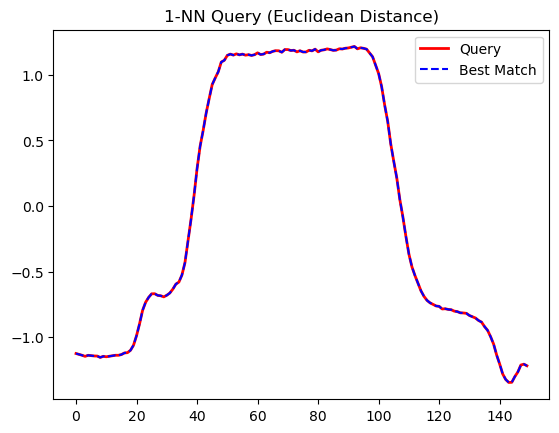

In [56]:
# Import dataset


# Load dataset
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")
X_train = X_train.squeeze()

# Squeeze to 2D (n_samples, time_length)(univariate)
X_train = X_train.squeeze()
X_test = X_test.squeeze()

query_ts = X_test[0]

# Compute Euclidean distances to all training samples
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

distances = np.array([euclidean_distance(query_ts, x) for x in X_test])

# Find best match
best_idx = np.argmin(distances)
best_match = X_test[best_idx]

print(f"Best match index: {best_idx}, Label: {y_test[best_idx]}")
print(f"Distance: {distances[best_idx]:.4f}")

# Plot
plt.plot(query_ts, label="Query", linewidth=2, color="red")
plt.plot(best_match, label="Best Match", linestyle="--", color="blue")
plt.legend()
plt.title("1-NN Query (Euclidean Distance)")
plt.show()



In [57]:
Q = X_test[y_test == 1][0]

In [58]:
P = 3
m = len(Q)
m_p = np.floor(m/3).astype(int)

P,m,m_p


(3, 150, np.int64(50))

In [59]:
# # Create P subsequences
# subsequences = [Q[i*m_p:(i+1)*m_p] for i in range(P)]

# # Print the subsequences to verify
# for idx, subseq in enumerate(subsequences):
#     print(f"Subsequence {idx+1}: {subseq}")
# len(subsequences)

In [60]:
# Example time series data (Q) and number of subsequences (P)
Q = X_test[y_test == 1][0]
P = 3

m = len(Q)
subseq_length = np.floor(m / P).astype(int)  # Length of each subsequence
remainder = m % P  # Remainder to distribute, how many subsequences should have one extra value

# Create P subsequences
subsequences = []
start_idx = 0

for i in range(P):
    # Determine the end index for the current subsequence
    end_idx = start_idx + subseq_length + (1 if i < remainder else 0) # For each subsequence, we add one extra element if the subsequence index is less than the remainder.
    subsequences.append(Q[start_idx:end_idx])
    start_idx = end_idx  # Update start index for next subsequence

# Print the subsequences to verify
for idx, subseq in enumerate(subsequences):
    print(f"Subsequence {idx+1}: {subseq}")
    print(len(subseq))

Subsequence 1: [-1.1250133  -1.1313383  -1.1382884  -1.1466873  -1.1386387  -1.1414312
 -1.1436908  -1.1443789  -1.1549123  -1.1464212  -1.1497246  -1.1457227
 -1.1419403  -1.1384288  -1.1385201  -1.1329855  -1.1206946  -1.1185964
 -1.1005789  -1.0618869  -0.98877018 -0.89804927 -0.79586606 -0.73432104
 -0.69687043 -0.66992052 -0.66910759 -0.68194036 -0.68481332 -0.69305372
 -0.68082429 -0.66386028 -0.63402064 -0.5958185  -0.58019191 -0.52662465
 -0.43224316 -0.27027162 -0.10318644  0.07854224  0.28436347  0.45409849
  0.57409933  0.70714616  0.8182297   0.92508286  0.97561574  1.0226481
  1.0969569   1.1102969 ]
50
Subsequence 2: [1.1479976 1.1575769 1.1498129 1.1594703 1.1517029 1.157521  1.1494632
 1.153298  1.1473326 1.1530236 1.1671015 1.1542641 1.1576391 1.1720068
 1.1678774 1.1783764 1.1837646 1.1829012 1.1717443 1.192459  1.1921674
 1.184896  1.1869894 1.1746437 1.183216  1.1736466 1.1736466 1.1868374
 1.1821363 1.1953776 1.174863  1.1868828 1.1903198 1.1972967 1.1923345
 1.186

In [61]:

l = 2
random.seed(20) 
for idx, subseq in enumerate(subsequences):
    new_length = random.randint(np.ceil(m_p/l).astype(int), np.ceil(m_p*l).astype(int))
    subsequences[idx] =nearest_neighbor_interpolation(subsequences[idx],new_length)
    print(f"Subsequence {idx+1}: {subseq}")
    print(len(subsequences[idx]))

    

Subsequence 1: [-1.1250133  -1.1313383  -1.1382884  -1.1466873  -1.1386387  -1.1414312
 -1.1436908  -1.1443789  -1.1549123  -1.1464212  -1.1497246  -1.1457227
 -1.1419403  -1.1384288  -1.1385201  -1.1329855  -1.1206946  -1.1185964
 -1.1005789  -1.0618869  -0.98877018 -0.89804927 -0.79586606 -0.73432104
 -0.69687043 -0.66992052 -0.66910759 -0.68194036 -0.68481332 -0.69305372
 -0.68082429 -0.66386028 -0.63402064 -0.5958185  -0.58019191 -0.52662465
 -0.43224316 -0.27027162 -0.10318644  0.07854224  0.28436347  0.45409849
  0.57409933  0.70714616  0.8182297   0.92508286  0.97561574  1.0226481
  1.0969569   1.1102969 ]
44
Subsequence 2: [1.1479976 1.1575769 1.1498129 1.1594703 1.1517029 1.157521  1.1494632
 1.153298  1.1473326 1.1530236 1.1671015 1.1542641 1.1576391 1.1720068
 1.1678774 1.1783764 1.1837646 1.1829012 1.1717443 1.192459  1.1921674
 1.184896  1.1869894 1.1746437 1.183216  1.1736466 1.1736466 1.1868374
 1.1821363 1.1953776 1.174863  1.1868828 1.1903198 1.1972967 1.1923345
 1.186

In [62]:
Q_scaled = np.concatenate(subsequences)

In [63]:
len(Q_scaled)

139

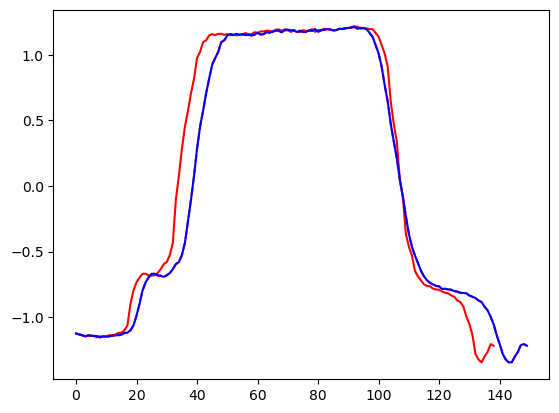

In [64]:
plt.plot(Q, color="red", linestyle='--')
plt.plot(Q_scaled, color="red")
plt.plot(X_test[0], color="blue")
# plt.axis('off')
plt.show()

In [65]:
test1 = nearest_neighbor_interpolation(Q_scaled, 50)
test2 = nearest_neighbor_interpolation(X_test[0], 50)

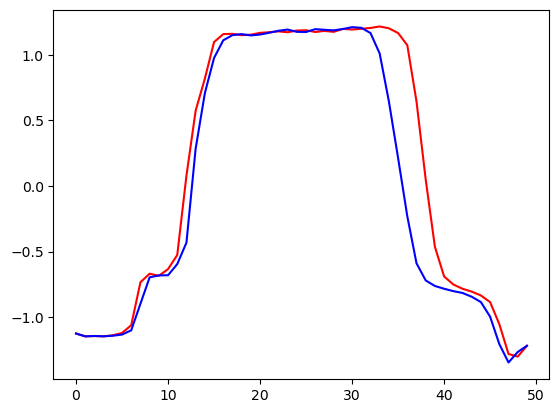

In [66]:
plt.plot(test1, color="red")
plt.plot(test2, color="blue")

In [67]:
L = int(np.ceil(min(2*len(test1), len(test2))/3))
L

17

We can discover the cutting points of segments by PSDTW.

In [68]:
D, backtrack, _ = ps_distance_p(test1, test2, 2, 0.1, L, 3, "dtw", lb_kim_fl) # 16580.84

In [69]:
backtrack

[((0, 21), (0, 22)), ((21, 33), (22, 29)), ((33, 50), (29, 50))]